<a href="https://colab.research.google.com/github/hijuliosantos/pos-chatbot/blob/main/AtividadeNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este trabalho tem como objetivo realizar a predição de avaliações positivas ou negativas de filmes, utilizando a base de dados imdb.csv. Serão utilizadas as bibliotecas NLTK, Regex e BeaultifulSoup para o pre-processameto das avaliações.

Será feita uma avaliação dividindo a base em treino e teste na proporção 80/20. Após isto, será calculada a acurácia para os seguintes modelo,s com o objtivo de verificar qual irá performar melhor:


1.   Regressão logística da biblioteca sklearn (ótima para classificação binária)
2.   SentimentIntensityAnalyzer da biblioteca NLTK









In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io
import re

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression # 

In [ ]:
import nltk
nltk.download(['stopwords', 'wordnet', 'vader_lexicon', 'punkt'])

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Leitura dos dados disponibilizados

In [ ]:
review = []
sentiment = []
with open('imdb.csv', 'r') as f:
  for line in f:
    line = line.replace(';','')
    review.append(line[0:line.rfind(',')])
    sentiment.append(line[line.rfind(',')+1:].strip().replace('"', ''))

df_imdb = pd.DataFrame()
df_imdb['review'] = review
df_imdb['sentiment'] = sentiment

df_imdb = df_imdb.iloc[1:]

Pequena análise exploratória nos dados

In [ ]:
print(df_imdb.shape)
df_imdb.head(10)

(50000, 2)


,review,sentiment
1,One of the other reviewers has mentioned that ...,positive
2,"""A wonderful little production. <br /><br />Th...",positive
3,"""I thought this was a wonderful way to spend t...",positive
4,Basically there's a family where a little boy ...,negative
5,"""Petter Mattei's """"Love in the Time of Money""""...",positive
6,"""Probably my all-time favorite movie, a story ...",positive
7,I sure would like to see a resurrection of a u...,positive
8,"This show was an amazing, fresh & innovative i...",negative
9,Encouraged by the positive comments about this...,negative
10,If you like original gut wrenching laughter yo...,positive


In [ ]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 1 to 50000
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df_imdb['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df_imdb['review'].loc[1]
#<br /><br />

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
stemmer = SnowballStemmer("english") 

print('Normal:')
review = df_imdb.iloc[1].review
print(review)
print()
review = BeautifulSoup(review, "html.parser").get_text()
print('BeautifulSoup:')
print(review)
print()
review = review.lower()
print('Lower:')
print(review)
print()
review = re.sub('[^a-z0-9]', ' ', review)
print('Regex a-z:')
print(review)
print()
review = nltk.word_tokenize(review)
review = [word for word in review if not word in stop_words]
print('Remove stop_words:')
print(review)
print()
review = [lem.lemmatize(word) for word in review]
print('lemmatize')
print(review)
#review = [stemmer.stem(word) for word in review]
#print('Stemming:')
#print(review)
print()
review = ' '.join(review)
print('Join:')
print(review)
print()

Normal:
"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly w

In [ ]:
def clean_data_review(df: pd.DataFrame) -> list:
  stop_words = set(stopwords.words('english'))
  #stemmer = SnowballStemmer("english") 
  lem = WordNetLemmatizer()
  cleaned_review = []
  for i in range(df.shape[0]):
    review = BeautifulSoup(df.iloc[i].review, "html.parser").get_text()
    review = review.lower()
    review = re.sub('[^a-z0-9]', ' ', review)
    review = nltk.word_tokenize(review)
    review = [word for word in review if not word in stop_words]
    review = [lem.lemmatize(word) for word in review]
    #review = [stemmer.stem(word) for word in review]
    review = ' '.join(review)
    cleaned_review.append(review)

  return cleaned_review

Limpeza dos dados e apresentação das palavras mais comuns após a limpeza.

In [ ]:
cleaned_review = clean_data_review(df_imdb)
df_imdb['cleaned_review'] = cleaned_review
df_imdb.tail()

,review,sentiment,cleaned_review
49996,I thought this movie did a down right good job...,positive,thought movie right good job creative original...
49997,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49998,"""I am a Catholic taught in parochial elementar...",negative,catholic taught parochial elementary school nu...
49999,"""I'm going to have to disagree with the previo...",negative,going disagree previous comment side maltin on...
50000,No one expects the Star Trek movies to be high...,negative,one expects star trek movie high art fan expec...


In [ ]:
print('Top 10 palavras mais comuns no geral:')
txt = df_imdb.cleaned_review.str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
print(word_dist.most_common(10))

Top 10 palavras mais comuns no geral:
[('movie', 103234), ('film', 93420), ('one', 55429), ('like', 41118), ('time', 31454), ('good', 29852), ('character', 28343), ('story', 25263), ('even', 24854), ('get', 24649)]


In [ ]:
print('Top 10 palavras mais comuns positivas:')
txt = df_imdb[df_imdb.sentiment == 'positive'].cleaned_review.str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
print(word_dist.most_common(10))

Top 10 palavras mais comuns positivas:
[('film', 49689), ('movie', 44833), ('one', 28278), ('like', 18193), ('time', 16309), ('good', 15089), ('story', 14181), ('character', 14019), ('great', 13009), ('see', 12926)]


In [ ]:
print('Top 10 palavras mais negativas:')
txt = df_imdb[df_imdb.sentiment == 'negative'].cleaned_review.str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
print(word_dist.most_common(10))

Top 10 palavras mais negativas:
[('movie', 58401), ('film', 43731), ('one', 27151), ('like', 22925), ('even', 15243), ('time', 15145), ('good', 14763), ('bad', 14714), ('character', 14324), ('would', 14005)]


*Poderiam ser feitos experimentos administrando melhor as palavras mais comuns, pois, notou se a presença de muitas palavras semelhantes entre as top 10 mais utilizadas para avaliações postivias e negativas.*

Abaixo será utilizada a técnica hould-out para avaliação dos dados. Será dividida a base em 80% treino e 20% testes, balanceando os dados pelo sentimento positivo/negativo. Também serão transformados os dados para aplicação no modelo de regressão logística.

In [ ]:
# Realizo um hould-out 80% treino / 20% teste, balanceando
X_train, X_test, y_train, y_test = train_test_split(df_imdb[['review', 'cleaned_review']], df_imdb['sentiment'], test_size=0.20, random_state=42, stratify=df_imdb['sentiment'], shuffle=True)

#count_vec = CountVectorizer()

# Para o modelo de regressão logística é necessário realizar a transformação do texto. 
# Com isto, será utilizada medida estatística TF-IDF bigram, que auxilia no balanceameento dos termos mais frequentes/menos frequentes
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2)) 
X_train_tfidf = tfidf_vec.fit_transform(X_train['cleaned_review'])
X_test_tfidf = tfidf_vec.transform(X_test['cleaned_review'])

# transformo os termos "positive" e "negative" em valores numéricos
y_train = (y_train.replace({'positive': 1, 'negative': 0})).values
y_test  = (y_test.replace({'positive': 1, 'negative': 0})).values

Nesta última etapa, serão criados os modelos e realizada a comparação entre eles através da acurácia de acertos.

In [ ]:
linear_svc = LogisticRegression()
linear_svc.fit(X_train_tfidf, y_train)
y_pred = linear_svc.predict(X_test_tfidf)

In [ ]:
tp_len = len(y_test[(y_test == y_pred) & (y_test == 1)])
tn_len = len(y_test[(y_test == y_pred) & (y_test == 0)])
positive_len = len(y_test[y_test == 1])
negative_len = len(y_test[y_test == 0])

print('Logistic regression model:')
print(f'TP count: {tp_len}/{positive_len} = {(tp_len/positive_len):.4f}%')
print(f'TN count: {tn_len}/{negative_len} = {(tn_len/negative_len):.4f}%')
print(f'General accuracy: {len(y_test[y_pred == y_test]) / len(y_test):.4f}%')

Logistic regression model:
TP count: 4537/5000 = 0.9074%
TN count: 4416/5000 = 0.8832%
General accuracy: 0.8953%


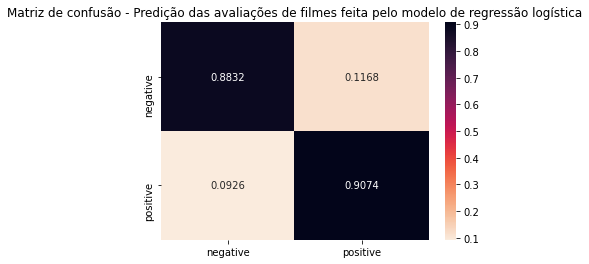

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm = np.transpose(cm.T / cm.astype(np.float).sum(axis=1))

plt.title('Matriz de confusão - Predição das avaliações de filmes feita pelo modelo de regressão logística')
sns.heatmap(cm, annot=True, fmt='.4f', cmap='rocket_r', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.show()

In [ ]:
def sia_predict(sia: SentimentIntensityAnalyzer, tx: str) -> int:
    return 1 if sia.polarity_scores(tx)["compound"] > 0 else 0

sia_y_pred = np.array([])

sia = SentimentIntensityAnalyzer()

for i, tx in enumerate(X_test.cleaned_review):
  sia_y_pred = np.append(sia_y_pred, sia_predict(sia, tx))

In [ ]:
print('NLTK sentiment intensity analyzer:')

sia_tp_len = len(y_test[(y_test == sia_y_pred) & (y_test == 1)])
sia_tn_len = len(y_test[(y_test == sia_y_pred) & (y_test == 0)])

print(f'TP count: {sia_tp_len}/{positive_len} = {(sia_tp_len/positive_len):.4f}%')
print(f'TN count: {sia_tn_len}/{negative_len} = {(sia_tn_len/negative_len):.4f}%')
print(f'General accuracy: {len(y_test[sia_y_pred == y_test]) / len(y_test):.4f}%')

NLTK sentiment intensity analyzer:
TP count: 4367/5000 = 0.8734%
TN count: 2380/5000 = 0.4760%
General accuracy: 0.6747%


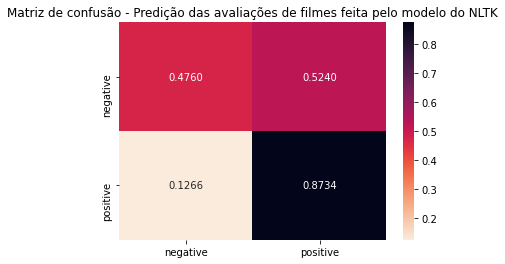

In [ ]:
cm = confusion_matrix(y_test, sia_y_pred)
cm = np.transpose(cm.T / cm.astype(np.float).sum(axis=1))

plt.title('Matriz de confusão - Predição das avaliações de filmes feita pelo modelo do NLTK')
sns.heatmap(cm, annot=True, fmt='.4f', cmap='rocket_r', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.show()

Com base nas execuções acima, o modelo de regressão logística obteve uma acurária maior em relação ao modelo de análise de sentimentos do NLTK. A acurácia das avaliações positivas ficou um pouco semelhante entre os dois modelos, porém, nas avaliações negativas, o modelo do NLTK não obteve muita performance.